In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext,SQLContext

In [0]:
sc = SparkContext()
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

In [0]:
import time

rtime = []

DEVICESTATUS DATA

In [0]:
import re

infile = "s3://srifinal007/devicestatus.txt"
d2 = sc.textFile("infile")
d3 = d2.map(lambda x: re.sub("[]\/|]", "," ,x).split(","))
d4 = d3.map(lambda x: (float(x[-2]), float(x[-1]), x[0], x[1].split()))
d5 = d4.map(lambda x: (x[0],x[1],x[2],x[3][0],x[3][1]))
d6 = d5.filter(lambda x: x[0] != 0 and x[1] != 0)

d6.take(3)

[(33.6894754264, -117.543308253, '2014-03-15:10:10:20', 'Sorrento', 'F41L'),
 (37.4321088904, -121.485029632, '2014-03-15:10:10:20', 'MeeToo', '1.0'),
 (39.4378908349, -120.938978486, '2014-03-15:10:10:20', 'MeeToo', '1.0')]

In [0]:
from pyspark.sql import types
df = spark.createDataFrame(d6, schema = types.StructType([types.StructField('Latitude', types.FloatType(),True),
                                                          types.StructField('Longtitude', types.FloatType(),True),
                                                          types.StructField('Date', types.StringType(),True),
                                                          types.StructField('Manufacturer', types.StringType(),True),
                                                          types.StructField('Model', types.StringType(),True)]))

In [0]:
from  pyspark.sql.functions import col,unix_timestamp, from_unixtime

df = df.withColumn('Date', from_unixtime(unix_timestamp(col('Date'), 'yy-MM-dd:HH:mm:ss').alias('Date')))
df = df.select(df.Latitude,df.Longtitude,df.Date,df.Manufacturer,df.Model)

In [0]:
outfile = "s3://srifinal007/parsed_data"

In [0]:
df.rdd.coalesce(1).saveAsTextFile(outfile)

# Parsed Data

In [0]:
data = sc.textFile("s3://srifinal007/parsed_data/")

In [333]:
print(data.take(1))

["Row(Latitude=33.689476013183594, Longtitude=-117.54330444335938, Date='2014-03-15 10:10:20', Manufacturer='Sorrento', Model='F41L')"]


In [0]:
import re
data = data.map(lambda x: ( re.sub("[A-Za-z\(]+=", "", x).replace(')','') )  )\
.map(lambda x: x.replace("'","").split(", "))\
.map(lambda x: ( float(x[0]), float(x[1]), x[2] , x[3], x[4]  ))

In [335]:
data.cache()

PythonRDD[2837] at RDD at PythonRDD.scala:53

In [336]:
from pyspark.sql import types
df = spark.createDataFrame(data, schema=types.StructType([\
                                                        types.StructField('Latitude', types.FloatType(),True),
                                                        types.StructField('Longitude', types.FloatType(),True),
                                                        types.StructField('Date', types.StringType(),True),
                                                        types.StructField('Manufacturer', types.StringType(),True),
                                                          types.StructField('Model', types.StringType(),True)]))
type(df)
df.show(1)

+---------+-----------+-------------------+------------+-----+
| Latitude|  Longitude|               Date|Manufacturer|Model|
+---------+-----------+-------------------+------------+-----+
|33.689476|-117.543304|2014-03-15 10:10:20|    Sorrento| F41L|
+---------+-----------+-------------------+------------+-----+
only showing top 1 row



In [337]:
df.cache()

DataFrame[Latitude: float, Longitude: float, Date: string, Manufacturer: string, Model: string]

In [339]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

vecAssembler = VectorAssembler(inputCols=["Latitude", "Longitude"], outputCol="features")
X = vecAssembler.transform(df)

# Model
model = (KMeans().setK(5).setSeed(1)).fit(X)

# Predictions
pred = model.transform(X)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Clusters
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)


Silhouette with squared euclidean distance = 0.7779851895575357
Cluster Centers: 
[  38.02864791 -121.23352192]
[  34.29718423 -117.78653245]
[  43.98989868 -122.77665336]
[  34.58818551 -112.35533553]
[  42.25924472 -116.90267328]


In [0]:
pred = pred.rdd.map(lambda x: (x[0], x[1], x[6], float(centers[x[6]][0]), float(centers[x[6]][1])))
pred_df = spark.createDataFrame(pred, schema = types.StructType([types.StructField('Latitude', types.FloatType(), True),
                                                                types.StructField('Longtitude', types.FloatType(), True),
                                                                types.StructField('Predictions', types.IntegerType(), True),
                                                                types.StructField('CCLatitude', types.FloatType(), True),
                                                                types.StructField('CCLongtitude', types.FloatType(), True)]))

In [341]:
pred_df.show(3)

+---------+-----------+-----------+----------+------------+
| Latitude| Longtitude|Predictions|CCLatitude|CCLongtitude|
+---------+-----------+-----------+----------+------------+
|33.689476|-117.543304|          1| 34.297184|  -117.78653|
| 37.43211| -121.48503|          0|  38.02865|  -121.23352|
| 39.43789| -120.93898|          0|  38.02865|  -121.23352|
+---------+-----------+-----------+----------+------------+
only showing top 3 rows



In [342]:
import pyspark.sql.functions as F

df = pred_df.withColumn("a", (
        F.pow(F.sin(F.radians(F.col("CCLatitude") - F.col("Latitude")) / 2), 2) +
        F.cos(F.radians(F.col("Latitude"))) * F.cos(F.radians(F.col("CCLatitude"))) *
        F.pow(F.sin(F.radians(F.col("CCLongtitude") - F.col("Longtitude")) / 2), 2)
    )).withColumn("GCDist", F.atan2(F.sqrt(F.col("a")), F.sqrt(-F.col("a") + 1)) * 6371).drop(F.col("a"))

newpred_df = df.withColumn("EucDis", F.pow( (F.col('CCLatitude') - F.col('Latitude')  ),2 ) + F.pow( (F.col('CCLongtitude') - F.col('Longtitude')  ),2 ) )
newpred_df.show(1)

+---------+-----------+-----------+----------+------------+-----------------+-------------------+
| Latitude| Longtitude|Predictions|CCLatitude|CCLongtitude|           GCDist|             EucDis|
+---------+-----------+-----------+----------+------------+-----------------+-------------------+
|33.689476|-117.543304|          1| 34.297184|  -117.78653|35.59862841593989|0.42846743379777763|
+---------+-----------+-----------+----------+------------+-----------------+-------------------+
only showing top 1 row



In [343]:
newpred_df.rdd.cache()
newpred_df.rdd.getStorageLevel()

StorageLevel(False, True, False, False, 1)

In [0]:
newpred_df.registerTempTable("newpred_df")

In [345]:
pdf = newpred_df.select("*").toPandas()
pdf.head()

,Latitude,Longtitude,Predictions,CCLatitude,CCLongtitude,GCDist,EucDis
0,33.689476,-117.543304,1,34.297184,-117.786530,35.598628,0.428467
1,37.432110,-121.485031,0,38.028648,-121.233521,34.961310,0.419116
2,39.437889,-120.938980,0,38.028648,-121.233521,79.384570,2.072713
3,39.363518,-119.400337,0,38.028648,-121.233521,108.786261,5.142437
4,33.191357,-116.448242,1,34.297184,-117.786530,87.220961,3.013867


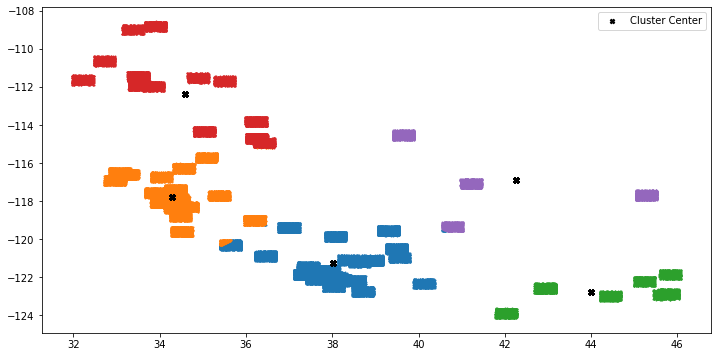

In [346]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (12, 6))
for i in range(5):
    mask = pdf.Predictions == i
    plt.scatter(pdf.Latitude[mask], pdf.Longtitude[mask], s = 1, alpha = 1)
plt.scatter(pdf.CCLatitude, pdf.CCLongtitude, label = "Cluster Center" , s = 20, marker = "X", color = 'black')
plt.legend()

SYNTHETIC DATA

In [321]:
infile = "s3://srifinal007/sample_geo.txt"

d1 = sc.textFile('infile').flatMap(lambda x: x.split("\n"))
d2 = d1.filter(lambda x: (x!="") and ("L" not in x) )
d3 = d2.map(lambda x: x.split("\t"))
d4 = d3.map(lambda x: (float(x[0]),float(x[1]),int(x[2])))
d4 = data
d4.take(1)

[(36.7, 3.216666666666667, '<http://dbpedia.org/resource/Algeria>')]

In [0]:
d4.cache()
d4.getStorageLevel()

StorageLevel(False, True, False, False, 1)

In [0]:
df2 = spark.createDataFrame(d4, schema=types.StructType([\
                                                        types.StructField('Latitude', types.FloatType(),True),
                                                        types.StructField('Longtitude', types.FloatType(),True)

]))

In [0]:
start_time = time.time()

vecAssembler = VectorAssembler(inputCols=["Latitude", "Longtitude"], outputCol="features")
X2 = vecAssembler.transform(df2)

X2.cache()
print(X2.rdd.getStorageLevel())

# Model
kmeans2 = KMeans().setK(2).setSeed(1)
model2 = kmeans2.fit(X2)

kmeans4 = KMeans().setK(4).setSeed(1)
model4 = kmeans4.fit(X2)

predictions2 = model2.transform(X2)
predictions4 = model4.transform(X2)

predictions2.cache()
predictions4.cache()

# Shows the result.
centers2 = model2.clusterCenters()
centers4 = model4.clusterCenters()
print("Cluster Centers K=2: ")
for center in centers2:
    print(center)
print("Cluster Centers K=4: ")
for center in centers4:
    print(center)

Serialized 1x Replicated
Cluster Centers K=2: 
[ 37.56474721 -82.55711082]
[  38.07161548 -116.43342043]
Cluster Centers K=4: 
[ 40.14836238 -76.96598964]
[  35.57495006 -113.07189577]
[  41.49405837 -121.33793417]
[ 35.11449777 -87.93102449]


K = 2

In [0]:
pred2 = predictions2.rdd.map(lambda x: (x[0],x[1],x[3],float(centers2[x[3]][0]),float(centers2[x[3]][1])))
df = spark.createDataFrame(pred2, schema=types.StructType([types.StructField('Latitude', types.FloatType(),True),
                                                          types.StructField('Longtitude', types.FloatType(),True),
                                                          types.StructField('Predictions', types.IntegerType(),True),
                                                          types.StructField('CCLatitude', types.FloatType(),True),
                                                          types.StructField('CCLongtitude', types.FloatType(),True)]))

In [0]:
import pyspark.sql.functions as F
df2 = df.withColumn("a", (
        F.pow(F.sin(F.radians(F.col("CCLatitude") - F.col("Latitude")) / 2), 2) +
        F.cos(F.radians(F.col("Latitude"))) * F.cos(F.radians(F.col("CCLatitude"))) *
        F.pow(F.sin(F.radians(F.col("CCLongtitude") - F.col("Longtitude")) / 2), 2)
    )).withColumn("GCDist", F.atan2(F.sqrt(F.col("a")), F.sqrt(-F.col("a") + 1)) * 6371).drop(F.col("a"))

df2 = df.withColumn("EucDis", F.pow( (F.col('CCLatitude') - F.col('Latitude')  ),2 ) + F.pow( (F.col('CCLongtitude') - F.col('Longtitude')  ),2 ) ).drop(F.col("EucDis"))
df2.show(1)

+--------+----------+-----------+----------+------------+-----------------+-----------------+
|Latitude|Longtitude|Predictions|CCLatitude|CCLongtitude|           GCDist|          EucDist|
+--------+----------+-----------+----------+------------+-----------------+-----------------+
|37.77254| -77.49955|          0|  40.14836|   -76.96599|268175.3106034865|5.929209526933846|
+--------+----------+-----------+----------+------------+-----------------+-----------------+
only showing top 1 row



In [0]:
df2.rdd.cache()

MapPartitionsRDD[880] at javaToPython at <unknown>:0

In [0]:
pandasdf2 = df2.select("*").toPandas()

In [0]:
pandasdf2.head()

,Latitude,Longtitude,Predictions,CCLatitude,CCLongtitude,GCDist,EucDis
0,37.772541,-77.499550,0,37.564747,-82.557114,23105.659653,0.043178
1,42.090134,-87.689156,0,37.564747,-82.557114,503200.054410,20.479126
2,39.563419,-75.587532,0,37.564747,-82.557114,222242.240395,3.994692
3,39.453022,-87.693741,0,37.564747,-82.557114,209966.616398,3.565583
4,38.953800,-77.016563,0,37.564747,-82.557114,154455.684772,1.929469


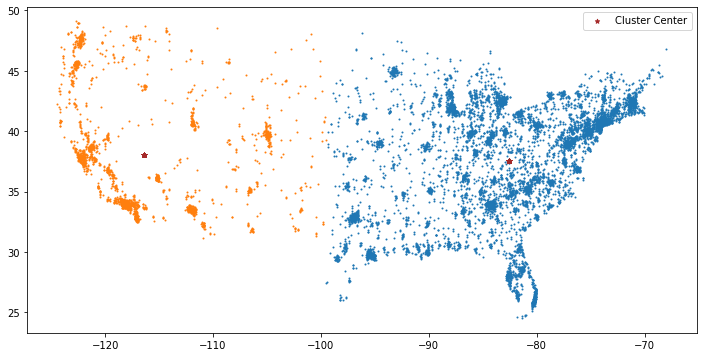

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(12, 6))
for i in range(2):
    mask = pandasdf2.Predictions == i
    plt.scatter(pandasdf2.Longtitude[mask], pandasdf2.Latitude[mask], s = 1, alpha = 1)
plt.scatter(pandasdf2.CCLongtitude, pandasdf2.CCLatitude, label = "Cluster Center", s = 20, marker = "*", color = 'brown')
plt.legend()

K = 4

In [0]:
pred4rdd = predictions4.rdd.map(lambda x: (x[0], x[1], x[3], float(centers4[x[3]][0]), float(centers4[x[3]][1])))
df4 = spark.createDataFrame(pred4rdd, schema=types.StructType([types.StructField('Latitude', types.FloatType(),True),
                                                               types.StructField('Longtitude', types.FloatType(),True),
                                                               types.StructField('Predictions', types.IntegerType(),True),
                                                               types.StructField('CCLatitude', types.FloatType(),True),
                                                               types.StructField('CCLongtitude', types.FloatType(),True)]))

In [0]:
import pyspark.sql.functions as F
df = df4.withColumn("a", (
        F.pow(F.sin(F.radians(F.col("CCLatitude") - F.col("Latitude")) / 2), 2) +
        F.cos(F.radians(F.col("Latitude"))) * F.cos(F.radians(F.col("CCLatitude"))) *
        F.pow(F.sin(F.radians(F.col("CCLongtitude") - F.col("Longtitude")) / 2), 2)
    )).withColumn("GCDist", F.atan2(F.sqrt(F.col("a")), F.sqrt(-F.col("a") + 1)) * 6371).drop(F.col("a"))

df = df.withColumn("EucDis", F.pow( (F.col('CCLatitude') - F.col('Latitude')  ),2 ) + F.pow( (F.col('CCLongtitude') - F.col('Longtitude')  ),2 ) )
df.show(1)

In [0]:
df.rdd.cache()

MapPartitionsRDD[910] at javaToPython at <unknown>:0

In [0]:
pandasdf3 = df.select("*").toPandas()

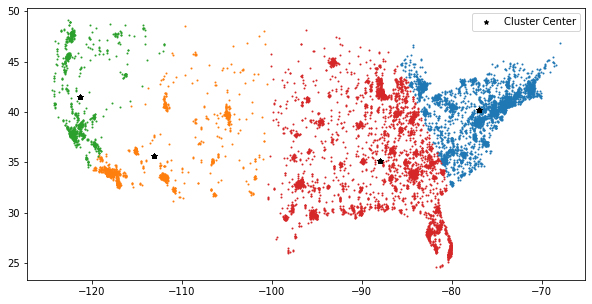

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10, 5))
for i in range(4):
    mask = pandasdf3.Predictions == i
    plt.scatter(pandasdf3.Longtitude[mask], pandasdf3.Latitude[mask], s=1)
plt.scatter(pandasdf3.CCLongtitude, pandasdf3.CCLatitude, label = "Cluster Center", s = 20, marker = "*", color = 'black')
plt.legend()

DBPEDIA

In [0]:
infile = "s3://srifinal007/lat_longs.txt"

d1 = sc.textFile("s3://srifinal007/lat_longs.txt")
d2 = d1.map(lambda x: x.split(" "))
d3 = d2.map(lambda x:(float(x[0]),float(x[1]),x[2]))
d3.take(1)

In [0]:
d3.cache()
d3.getStorageLevel()

StorageLevel(False, True, False, False, 1)

In [0]:
from pyspark.sql import types
sparkdbpedia = spark.createDataFrame(d3, schema=types.StructType([types.StructField('Latitude', types.FloatType(),True),
                                                          types.StructField('Longtitude', types.FloatType(),True),
                                                          types.StructField('Site', types.StringType(),True)]))
sparkdbpedia.show(1)

+--------+----------+--------------------+
|Latitude|Longtitude|                Site|
+--------+----------+--------------------+
|    36.7| 3.2166667|<http://dbpedia.o...|
+--------+----------+--------------------+
only showing top 1 row



In [0]:
sparkdbpedia.rdd.cache()

MapPartitionsRDD[2309] at javaToPython at <unknown>:0

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import time
start_time = time.time()

vecAssembler = VectorAssembler(inputCols=["Latitude", "Longtitude"], outputCol="features")
X3 = vecAssembler.transform(sparkdbpedia)

X3.rdd.cache()

# Model
kmeans2 = KMeans().setK(2).setSeed(1)
model2 = kmeans2.fit(X3)

kmeans4 = KMeans().setK(4).setSeed(1)
model4 = kmeans4.fit(X3)

pred2 = model2.transform(X3)
pred4 = model4.transform(X3)

pred2.rdd.cache()
pred4.rdd.cache()


# Shows the result.
centers2 = model2.clusterCenters()
centers4 = model4.clusterCenters()

print("Cluster Centers K=2: ")
for center in centers2:
    print(center)
print("Cluster Centers K=4: ")
for center in centers4:
    print(center)

Cluster Centers K=2: 
[40.18205687 32.48327172]
[ 35.94167287 -88.83209608]
Cluster Centers K=4: 
[48.43652453  9.99936844]
[ 35.93470852 -88.9150858 ]
[ 18.51080852 123.643959  ]
[28.35921384 56.72666129]


K = 4

In [0]:
pred4rdd = predictions4.rdd.map(lambda x: (x[0],x[1],x[4],float(centers4[x[4]][0]),float(centers4[x[4]][1])))
df4 = spark.createDataFrame(pred4rdd, schema=types.StructType([types.StructField('Latitude', types.FloatType(),True),
                                                                    types.StructField('Longtitude', types.FloatType(),True),
                                                                    types.StructField('Predictions', types.IntegerType(),True),
                                                                    types.StructField('CCLatitude', types.FloatType(),True),
                                                                    types.StructField('CCLongtitude', types.FloatType(),True)]))

In [0]:
import pyspark.sql.functions as F
df = df4.withColumn("a", (
        F.pow(F.sin(F.radians(F.col("CCLatitude") - F.col("Latitude")) / 2), 2) +
        F.cos(F.radians(F.col("Latitude"))) * F.cos(F.radians(F.col("CCLatitude"))) *
        F.pow(F.sin(F.radians(F.col("CCLongtitude") - F.col("Longtitude")) / 2), 2)
    )).withColumn("GCDist", F.atan2(F.sqrt(F.col("a")), F.sqrt(-F.col("a") + 1)) * 6371).drop(F.col("a"))

newdf4 = df.withColumn("EucDis", F.pow( (F.col('CCLatitude') - F.col('Latitude')  ),2 ) + F.pow( (F.col('CCLongtitude') - F.col('Longtitude')  ),2 ) )
newdf4.show(1)

+--------+----------+-----------+----------+------------+-----------------+------------------+
|Latitude|Longtitude|Predictions|CCLatitude|CCLongtitude|           GCDist|            EucDis|
+--------+----------+-----------+----------+------------+-----------------+------------------+
|    36.7| 3.2166667|          0| 48.436523|    9.999369|708.4618533443007|183.75101049274076|
+--------+----------+-----------+----------+------------+-----------------+------------------+
only showing top 1 row



In [0]:
pandasdf4 = newdf4.select("*").toPandas()

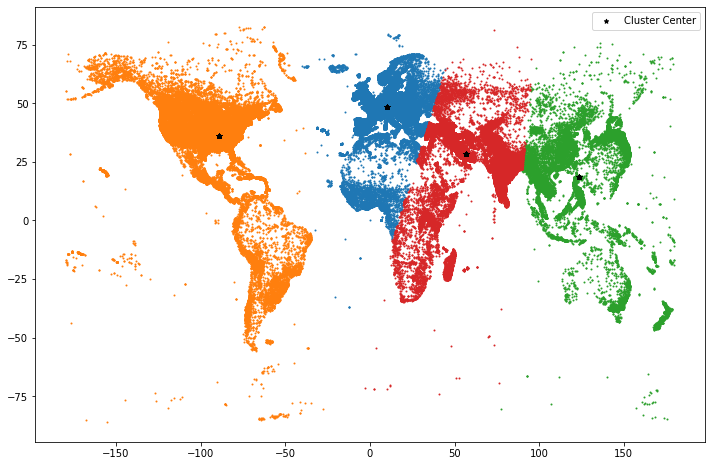

In [330]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (12, 8))
for i in range(4):
    mask = pandasdf4.Predictions == i
    plt.scatter(pandasdf4.Longtitude[mask], pandasdf4.Latitude[mask], s = 1, alpha = 1)
plt.scatter(pandasdf4.CCLongtitude, pandasdf4.CCLatitude, label = "Cluster Center", s = 20, marker = "*", color = 'black')
plt.legend()

K = 2

In [0]:
pred2rdd = predictions2.rdd.map(lambda x: (x[0],x[1],x[4],float(centers6[x[4]][0]),float(centers6[x[4]][1])))
df2 = spark.createDataFrame(pred2rdd, schema=types.StructType([types.StructField('Latitude', types.FloatType(),True),
                                                               types.StructField('Longtitude', types.FloatType(),True),
                                                               types.StructField('Predictions', types.IntegerType(),True),
                                                               types.StructField('CCLatitude', types.FloatType(),True),
                                                               types.StructField('CCLongtitude', types.FloatType(),True)]))

In [0]:
df = df2.withColumn("a", (F.pow(F.sin(F.radians(F.col("CCLatitude") - F.col("Latitude")) / 2), 2) +
                    F.cos(F.radians(F.col("Latitude"))) * F.cos(F.radians(F.col("CCLatitude"))) *
                    F.pow(F.sin(F.radians(F.col("CCLongtitude") - F.col("Longtitude")) / 2), 2)
                    )).withColumn("GCDist", F.atan2(F.sqrt(F.col("a")), F.sqrt(-F.col("a") + 1)) * 6371).drop(F.col("a"))

newdf2 = df.withColumn("EucDis", F.pow( (F.col('CCLatitude') - F.col('Latitude')  ),2 ) + F.pow( (F.col('CCLongtitude') - F.col('Longtitude')  ),2 ) )
newdf2.show(1)

+--------+----------+-----------+----------+------------+-----------------+------------------+
|Latitude|Longtitude|Predictions|CCLatitude|CCLongtitude|           GCDist|            EucDis|
+--------+----------+-----------+----------+------------+-----------------+------------------+
|    36.7| 3.2166667|          0|  48.59884|      9.7733|713.1443294349903|184.57178927056543|
+--------+----------+-----------+----------+------------+-----------------+------------------+
only showing top 1 row



In [0]:
pandasdf2 = newdf2.select("*").toPandas()

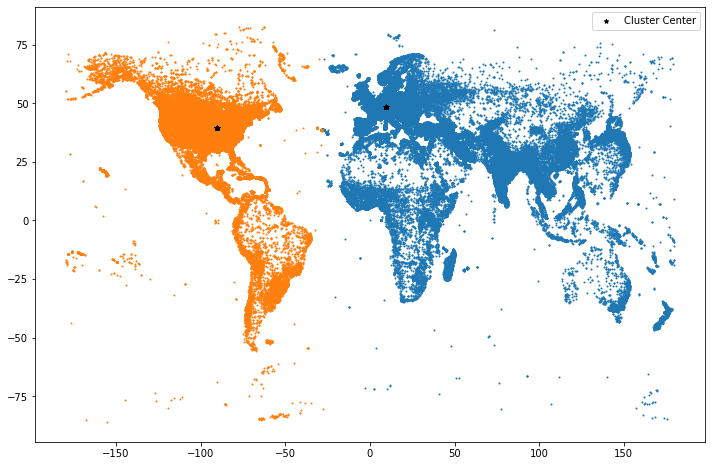

In [331]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (12, 8))
for i in range(6):
    mask = pandasdf2.Predictions == i
    plt.scatter(pandasdf2.Longtitude[mask], pandasdf2.Latitude[mask], s = 1, alpha = 1)
plt.scatter(pandasdf2.CCLongtitude, pandasdf2.CCLatitude, label = "Cluster Center", s = 20, marker = "*", color = 'black')
plt.legend()